In [ ]:
%%capture
!pip install pytorch-lightning
!pip install grad-cam
!pip install wandb

from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pytorch_lightning as pl
import wandb
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from os import listdir
from os.path import isfile, join

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

drive.mount('/content/drive')
%load_ext tensorboard

In [ ]:
class PneumoniaClassifier(pl.LightningModule):

    def __init__(self, learning_rate=1e-5):
        super().__init__()
        resnet = models.resnet50(pretrained = True)
        self.model = resnet
        output_feats = self.model.fc.out_features
        classifier = nn.Sequential(*[nn.Linear(output_feats, 2)])
        #classifier = nn.Sequential(*[nn.Linear(output_feats, 1)])
        self.classifier = classifier
        
        import wandb
        from pytorch_lightning.loggers import WandbLogger
        #wandb.init()

        self.learning_rate = learning_rate
        
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2, average='macro')

        self.val_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.val_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        self.test_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.test_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        self.current_f1 = 0
        self.max_f1 = 0
        
    def forward(self, x):

        x = self.model(x)       
        x = torch.squeeze(x)
        x = self.classifier(x)
        #x = torch.squeeze(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels, weight=torch.cuda.FloatTensor([100,1]))
        #return F.cross_entropy(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc, prog_bar = True)
        self.val_f1(logits, y)
        self.log("valid_f1", self.val_f1)
        self.val_auroc(logits,y)
        self.log('valid_auroc', self.val_auroc)
        self.confusion_matrix.update(logits, y)

    def on_validation_epoch_end(self):
        print("Confusion matrix")
        print(self.confusion_matrix.compute())
        self.confusion_matrix.reset()

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)
        self.test_f1.update(logits, y)
        self.log('test_f1', self.test_f1)
        self.test_auroc(logits,y)
        self.log('test_auroc', self.test_auroc)
        self.confusion_matrix.update(logits, y)

    def check_gradcam(self, dataloader, target_layer, target_category, reshape_transform=None):
        cam = GradCAM(
            model=self,
            target_layers=[target_layer], 
            use_cuda=True)
    
        org_images, labels = iter(dataloader).next()
        cam.batch_size = len(org_images)
        #images = self.transform['val'](org_images)
        images = org_images.to(self.device)
        logits = self.forward(images).squeeze(1)
        pred = logits.sigmoid().detach().cpu().numpy() * 100
        labels = labels.cpu().numpy()
        
        targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
        grayscale_cam = cam(input_tensor=images)#, target_category = target_category)#, target_category=target_category, eigen_smooth=True)
        #org_images_copy = unorm(org_images).detach().cpu().numpy().transpose(0, 2, 3, 1)
        org_images_copy = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1)

        return org_images_copy, grayscale_cam, pred, labels, org_images


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        #optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)#, weight_decay=0.001)

        return optimizer


In [ ]:
from torchvision.transforms.transforms import CenterCrop
from torch.autograd._functions.tensor import Resize
from torchvision.datasets import ImageFolder

class PneumoniaDataModule(pl.LightningDataModule):
    def setup(self, stage):

        self.data_path = "/content/drive/MyDrive/chest_xray" # path of the training data 
        self.transform = transforms.Compose([
             transforms.Resize((240, 240)),
             transforms.Grayscale(3),
             #transforms.CenterCrop((224,224)),
             transforms.ToTensor(),
             #transforms.RandomAffine(degrees=8, scale=(.95, 1.05), shear=0),
             transforms.RandomCrop((224,224)),
             #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
             ])
      
        trainset = torchvision.datasets.ImageFolder(self.data_path+'/train', transform=self.transform)
        valset = torchvision.datasets.ImageFolder(self.data_path+'/val', transform=self.transform)
        testset = torchvision.datasets.ImageFolder(self.data_path+'/test', transform=self.transform)

        train_size = int(0.9 * len(trainset))
        test_size = len(trainset) - train_size
        trainset, additional_val_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])
        valset = torch.utils.data.ConcatDataset([valset, additional_val_dataset])

        self.trainset = trainset
        self.valset = valset
        self.testset = testset
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=16,
                                         shuffle=False, num_workers=2)
        
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=16,
                                         shuffle=False, num_workers=2)

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="valid_f1", filename="sample-pneumonia-{epoch:02d}-{valid_f1:.2f}", mode="max", save_top_k=10)

torch.cuda.empty_cache()
AVAIL_GPUS = min(1, torch.cuda.device_count())
data_module = PneumoniaDataModule()
model = PneumoniaClassifier(learning_rate=1e-5)

#wandb_logger = WandbLogger(save_dir='wdb_log',name='resnet_model',project="RESNET", log_model="all")
#tb_logger = TensorBoardLogger(save_dir="tb_logs", name="resnet_model")

#wandb.watch(model, log='all')

trainer = pl.Trainer(gpus = AVAIL_GPUS, auto_lr_find=True, max_epochs = 10,callbacks = [checkpoint_callback])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model = PneumoniaClassifier()
model = PneumoniaClassifier.load_from_checkpoint('sample-pneumonia-epoch=08-valid_f1=0.93.ckpt')


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9310897588729858
       test_auroc            0.967740535736084
         test_f1            0.9250601530075073
        test_loss           0.3056412935256958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
tensor([[202,  32],
        [ 11, 379]])


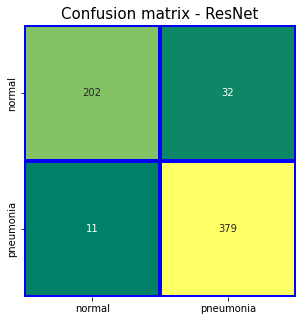

In [ ]:
trainer.test(model, data_module)
print(model.confusion_matrix.compute())

import seaborn as sns
fig = plt.figure(figsize=(5,5))
sns.heatmap(model.confusion_matrix.compute(), annot=True,cmap='summer',square=True, xticklabels=['normal','pneumonia'],yticklabels=['normal','pneumonia'],fmt="d", cbar=False,linewidths=3, linecolor='b')
plt.title('Confusion matrix - ResNet',fontsize=15)
model.confusion_matrix.reset()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

h1 = model.model.fc.register_forward_hook(getActivation('avgpool'))

all_labels = []
all_outputs = []
data_flatten = []
#dataiter = iter(data_module.test_dataloader())
#images, labels = dataiter.next()
for i, data in enumerate(data_module.test_dataloader(), 0):
  with torch.no_grad():
    images, labels = data
    #images = images.cuda()
    outputs = model(images)
    features = np.array(activation['avgpool'].cpu())

    all_labels += labels
    all_outputs += outputs
    data_flatten += features.tolist()

#outputs = model(images)

labels = all_labels
outputs = all_outputs


#data_flatten = np.array(activation['fc'])

label_flatten_unique = np.unique(np.array(labels))
label_flatten = np.array(labels)

false_idx = []
for i,(l,o) in enumerate(zip(labels,outputs)):
  false_idx.append((l==torch.argmax(o)).item())
  
#X = activation['fc'].numpy()
X = np.array(data_flatten)
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=45,
                  init='random').fit_transform(X)
X_embedded.shape

plt.style.use("ggplot")
plt.figure(figsize=(12,10))

markers = ["o","v"]
col = [True, False]
colours = ['b', 'r']
for j, c in enumerate(np.unique(col)):
    #plt.scatter(y[:,0][col==c],y[:,1][col==c],c=col[col==c], marker=markers[i])
    for n, g in enumerate(label_flatten_unique):
        i1 = np.where(label_flatten==g)
        i2 = np.where(col[j]==np.array(false_idx))
        i =  np.intersect1d(i1,i2)
        if j==0 and n==0:
          legend_label = 'true normal'
        elif j==0 and n==1:
          legend_label = 'true pneumonia'
        elif j==1 and n==0:
          legend_label = 'false pneumonia'
        elif j==1 and n==1:
          legend_label = 'false normal'
        plt.scatter(X_embedded[i,0], X_embedded[i,1], label=legend_label, marker = markers[j], color=colours[n])
plt.legend() 
plt.show()

KeyboardInterrupt: ignored

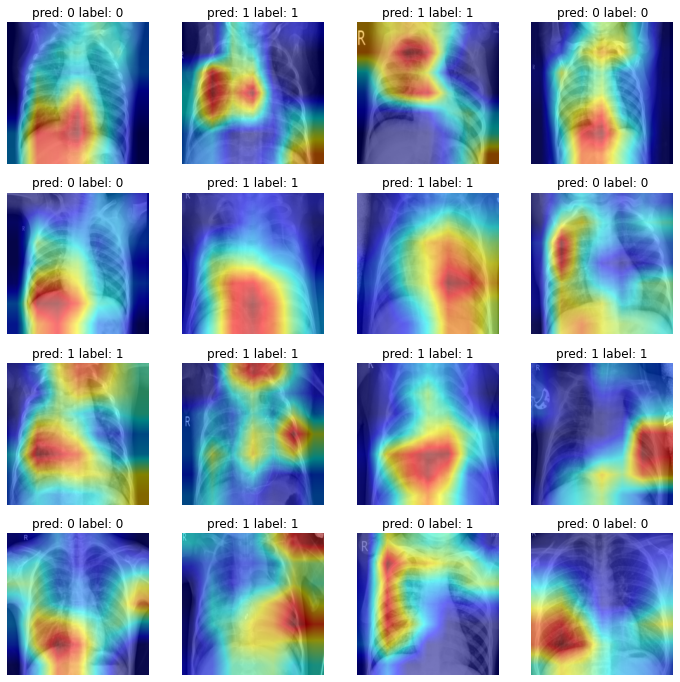

In [ ]:
import cv2

images, grayscale_cams, preds, labels, org_img = model.check_gradcam(
                                            data_module.test_dataloader(), 
                                            target_layer=model.model.layer4[-1],
                                            target_category=0,
                                            )

plt.figure(figsize=(12, 12))
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

image_list = []
titles = []

for it, (image, grayscale_cam, pred, label) in enumerate(zip(images, grayscale_cams, preds, labels)):
    plt.subplot(4, 4, it + 1)
    #print(np.max(rgb2gray(image)))
    #visualization = show_cam_on_image(np.dstack([rgb2gray(image)]*3), grayscale_cam)
    visualization = show_cam_on_image(image, grayscale_cam)
    cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
    plt.imshow(cam_image)
    if (pred[0]>pred[1]):
      pred_class = 0
    else:
      pred_class = 1
    plt.title(f'pred: {pred_class} label: {label}')
    plt.axis('off')

    image_list.append(cam_image)
    titles.append(f'pred: {pred_class} label: {label}')